# Initialization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, DecimalType, IntegerType
from pyspark.sql.functions import col
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /scratch/mjain3/job_30270859/matplotlib-9nruscdo because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Create a Spark session
# spark = SparkSession.builder \
#     .appName("Yellow Taxi EDA") \
#     .getOrCreate()


# I ran this notebook successfully using 4 cores and 8GB per node in the jupyter session setup. 
# Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting.
spark = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
	.config("spark.executor.memory", "4g") \
    .config('spark.executor.instances', 6) \
	.appName("Yellow Taxi EDA") \
	.getOrCreate()

# Importing Data

In [4]:
base_path = '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-{:02d}.parquet'
paths = []

for month in range(1, 7):  # This loops from 1 to 12
    path = base_path.format(month)  # Formats the month with leading zero if necessary
    paths.append(path)

In [5]:
paths

['/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-01.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-02.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-03.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-04.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-05.parquet',
 '/home/mjain3/uci150/mjain3/yellow_taxi_data/yellow_tripdata_2023-06.parquet']

In [6]:
# Function to load and cast a single Parquet file
def load_and_cast(filepath):
    df = spark.read.parquet(filepath)
    df = df.withColumn("VendorID", col("VendorID").cast(IntegerType()))
    return df

# Load, cast, and accumulate all DataFrames
dataframes = [load_and_cast(path) for path in paths]
df = reduce(lambda df1, df2: df1.unionByName(df2), dataframes)

# Show the DataFrame
df.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

In [7]:
df.count()

19493620

In [8]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# EDA 

In [9]:
from pyspark.sql.functions import col, count, isnan, desc

# Summary statistics for numeric fields
numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount', 'total_amount']
df.select(numeric_cols).describe().show()

# Count of missing values for each column, adjusted to not use isnan for non-numeric fields
for col_name in df.columns:
    if df.schema[col_name].dataType == "DoubleType" or df.schema[col_name].dataType == "FloatType":
        missing_count = df.filter((col(col_name).isNull()) | (isnan(col_name))).count()
    else:
        missing_count = df.filter(col(col_name).isNull()).count()
    print(f"Missing values in {col_name}: {missing_count}")

# Correlation between numeric fields
for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 != col2:
            corr_value = df.stat.corr(col1, col2)
            print(f"Correlation between {col1} and {col2}: {corr_value:.2f}")

# Most common values for categorical fields
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type']
for col_name in categorical_cols:
    df.groupBy(col_name).count().orderBy(desc("count")).show()


+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|   passenger_count|     trip_distance|       fare_amount|       tip_amount|     total_amount|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|          18965068|          19493620|          19493620|         19493620|         19493620|
|   mean|1.3629848308479569| 4.080598819510947|19.154405136142593|3.499121566954948|28.04725801254911|
| stddev| 0.892183932044041|249.64444355975652|  89.5893771550846|4.020777372772306|90.65430877134082|
|    min|               0.0|               0.0|            -959.9|           -411.0|          -982.95|
|    max|               9.0|         342344.85|         386983.63|            984.3|        386987.63|
+-------+------------------+------------------+------------------+-----------------+-----------------+

Missing values in VendorID: 0
Missing values in tpep_pickup_datetime: 0


## 1. Fare amount vs Tip Amount

In [10]:
# Sampling a fraction of the data for visualization
sampled_df = df.sample(fraction=0.1, withReplacement=False)# Converting Spark DataFrame to Pandas DataFrame

In [11]:
# Converting Spark DataFrame to Pandas DataFrame
pandas_df = sampled_df.select("fare_amount", "tip_amount").toPandas()

<Figure size 1200x600 with 0 Axes>

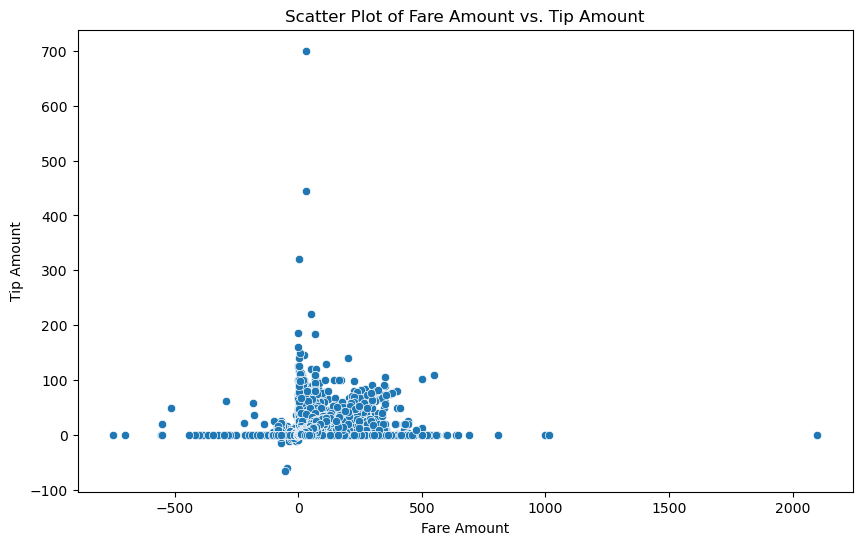

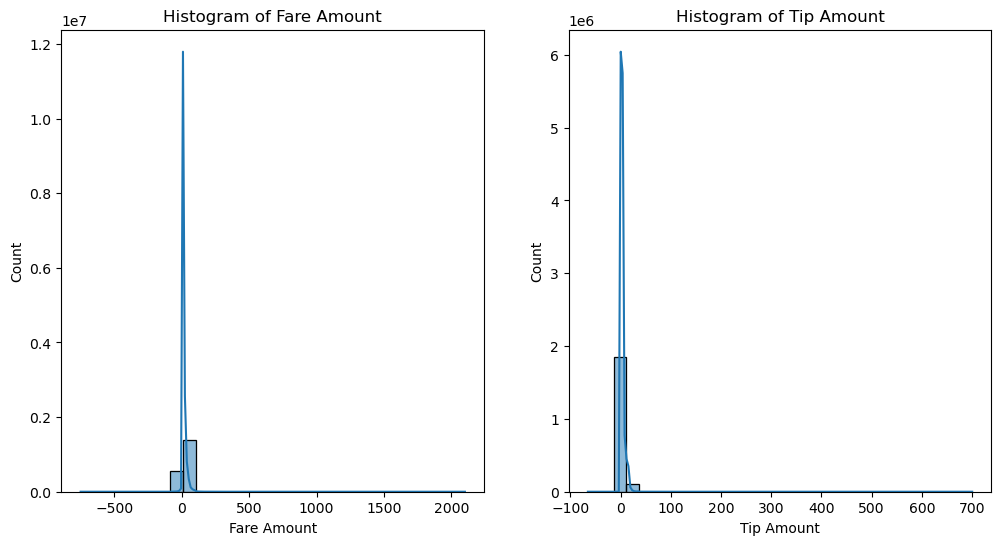

In [13]:
# Boxplot for fare_amount and tip_amount
plt.figure(figsize=(12, 6))

# Scatter plot to observe the relationship between fare amount and tip amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fare_amount', y='tip_amount', data=pandas_df)
plt.title('Scatter Plot of Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Tip Amount')
plt.show()

# Histograms to view the distributions of fare amount and tip amount
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['fare_amount'], kde=True, bins=30)
plt.title('Histogram of Fare Amount')
plt.xlabel('Fare Amount')

plt.subplot(1, 2, 2)
sns.histplot(pandas_df['tip_amount'], kde=True, bins=30)
plt.title('Histogram of Tip Amount')
plt.xlabel('Tip Amount')
plt.show()
